# Lazy loading with Xarray

---

## Overview
When dealing with massive datasets, loading all the data into memory at once may not be feasible due to resource limitations. Lazy loading allows you to load and process data in smaller, manageable chunks or batches, reducing the memory footprint and enabling more efficient analysis. Many modern data servers allow for lazy loading via, for example, xarray. 
1. Using Xarray for lazy loading via URL
2. Using Kerchunk when a URL doesn't work out of the box
3. Bonuses of Kerchunk?

## Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Xarray]() | Necessary | |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Helpful | Familiarity with metadata structure |

- **Time to learn**: 10 minutes

---

## Imports

In [27]:
import sys
import os
import gc
import xarray as xr
import fsspec
import json
import ujson
from pathlib import Path
from kerchunk.netCDF3 import NetCDF3ToZarr


In [5]:
PF_data_dir = Path('/Users/jlanders/PycharmProjects/PangeoForge_recipes/C-iTRACE/data')

In [104]:
def actualsize(input_obj):
    memory_size = 0
    ids = set()
    objects = [input_obj]
    while objects:
        new = []
        for obj in objects:
            if id(obj) not in ids:
                ids.add(id(obj))
                memory_size += sys.getsizeof(obj)
                new.append(obj)
        objects = gc.get_referents(*new)
    return memory_size

## Xarray for loading via URL

In [128]:
month = '13'
po4_woa = xr.open_dataset('https://www.ncei.noaa.gov/thredds-ocean/dodsC/ncei/woa/phosphate/all/1.00/woa18_all_p{}_01.nc'.format(month),
                         decode_times=False, chunks={"depth": 10})
# woa_snapshot_data = po4_woa.sel(depth=100)
print('po4_woa = {} mb'.format(actualsize(po4_woa)/1000**2))
po4_woa['p_mn']

po4_woa = 308.295106 mb


<xarray.DataArray 'p_mn' (time: 1, depth: 43, lat: 180, lon: 360)>
dask.array<open_dataset-8c1cf14b5686596b773268bf12ef4643p_mn, shape=(1, 43, 180, 360), dtype=float32, chunksize=(1, 10, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * depth    (depth) float32 0.0 5.0 10.0 15.0 20.0 ... 650.0 700.0 750.0 800.0
  * time     (time) float32 697.5
Attributes:
    standard_name:  moles_concentration_of_phosphate_in_sea_water
    long_name:      Average of all unflagged interpolated values at each stan...
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    units:          micromoles_per_kilogram

In [135]:
month = '13'
temp_woa = xr.open_dataset('https://www.ncei.noaa.gov/thredds-ocean/dodsC/woa23/DATA/temperature/netcdf/decav91C0/1.00/woa23_decav91C0_t16_01.nc',
                         decode_times=False, chunks={"depth": 10}
                          )
# woa_snapshot_data = po4_woa.sel(depth=100)
print('temp_woa = {} mb'.format(actualsize(temp_woa)/1000**2))
temp_woa

temp_woa = 318.185071 mb


<xarray.Dataset>
Dimensions:             (lat: 180, nbounds: 2, lon: 360, depth: 102, time: 1)
Coordinates:
  * lat                 (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon                 (lon) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * depth               (depth) float32 0.0 5.0 10.0 ... 5.3e+03 5.4e+03 5.5e+03
  * time                (time) float32 178.5
Dimensions without coordinates: nbounds
Data variables: (12/13)
    crs                 int32 ...
    lat_bnds            (lat, nbounds) float32 dask.array<chunksize=(180, 2), meta=np.ndarray>
    lon_bnds            (lon, nbounds) float32 dask.array<chunksize=(360, 2), meta=np.ndarray>
    depth_bnds          (depth, nbounds) float32 dask.array<chunksize=(10, 2), meta=np.ndarray>
    climatology_bounds  (time, nbounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    t_an                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 10, 180, 360), meta=np.ndarray>
    ...                  ...
    t_dd                (time, depth, lat, lon) float64 dask.array<chunksize=(1, 10, 180, 360), meta=np.ndarray>
    t_sd                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 10, 180, 360), meta=np.ndarray>
    t_se                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 10, 180, 360), meta=np.ndarray>
    t_oa                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 10, 180, 360), meta=np.ndarray>
    t_ma                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 10, 180, 360), meta=np.ndarray>
    t_gp                (time, depth, lat, lon) float64 dask.array<chunksize=(1, 10, 180, 360), meta=np.ndarray>
Attributes: (12/45)
    Conventions:                     CF-1.6
    title:                           World Ocean Atlas 2023 : sea_water_tempe...
    summary:                         Climatological mean temperature for the ...
    references:                      Locarnini, R. A., O. K. Baranova, A. V. ...
    institution:                     NOAA National Centers for Environmental ...
    comment:                         Global Climatology as part of the World ...
    ...                              ...
    ncei_template_version:           NCEI_NetCDF_Grid_Template_v1.0
    license:                         These data are openly available to the p...
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    metadata_link:                   https://www.ncei.noaa.gov/products/world...
    date_created:                    2022-09-29 
    date_modified:                   2022-09-29

Pre `.compute()`

In [136]:
_tmp = temp_woa.sel(depth = 5)
print('_tmp = {} mb'.format(actualsize(_tmp)/1000**2))
_tmp

_tmp = 318.23907 mb


<xarray.Dataset>
Dimensions:             (lat: 180, nbounds: 2, lon: 360, time: 1)
Coordinates:
  * lat                 (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon                 (lon) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
    depth               float32 5.0
  * time                (time) float32 178.5
Dimensions without coordinates: nbounds
Data variables: (12/13)
    crs                 int32 ...
    lat_bnds            (lat, nbounds) float32 dask.array<chunksize=(180, 2), meta=np.ndarray>
    lon_bnds            (lon, nbounds) float32 dask.array<chunksize=(360, 2), meta=np.ndarray>
    depth_bnds          (nbounds) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    climatology_bounds  (time, nbounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    t_an                (time, lat, lon) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    ...                  ...
    t_dd                (time, lat, lon) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    t_sd                (time, lat, lon) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    t_se                (time, lat, lon) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    t_oa                (time, lat, lon) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    t_ma                (time, lat, lon) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    t_gp                (time, lat, lon) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
Attributes: (12/45)
    Conventions:                     CF-1.6
    title:                           World Ocean Atlas 2023 : sea_water_tempe...
    summary:                         Climatological mean temperature for the ...
    references:                      Locarnini, R. A., O. K. Baranova, A. V. ...
    institution:                     NOAA National Centers for Environmental ...
    comment:                         Global Climatology as part of the World ...
    ...                              ...
    ncei_template_version:           NCEI_NetCDF_Grid_Template_v1.0
    license:                         These data are openly available to the p...
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    metadata_link:                   https://www.ncei.noaa.gov/products/world...
    date_created:                    2022-09-29 
    date_modified:                   2022-09-29

Post `.compute()`

In [137]:
_tmp = _tmp.compute()
print('_tmp = {} mb'.format(actualsize(_tmp)/1000**2))
_tmp

_tmp = 320.868757 mb


<xarray.Dataset>
Dimensions:             (lat: 180, nbounds: 2, lon: 360, time: 1)
Coordinates:
  * lat                 (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon                 (lon) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
    depth               float32 5.0
  * time                (time) float32 178.5
Dimensions without coordinates: nbounds
Data variables: (12/13)
    crs                 int32 -2147483647
    lat_bnds            (lat, nbounds) float32 -90.0 -89.0 -89.0 ... 89.0 90.0
    lon_bnds            (lon, nbounds) float32 -180.0 -179.0 ... 179.0 180.0
    depth_bnds          (nbounds) float32 2.5 7.5
    climatology_bounds  (time, nbounds) float32 9.0 360.0
    t_an                (time, lat, lon) float32 nan nan nan ... -1.687 -1.687
    ...                  ...
    t_dd                (time, lat, lon) float64 nan nan nan nan ... 0.0 0.0 0.0
    t_sd                (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    t_se                (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    t_oa                (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    t_ma                (time, lat, lon) float32 nan nan ... -0.01431 -0.01431
    t_gp                (time, lat, lon) float64 nan nan nan ... 69.0 71.0 71.0
Attributes: (12/45)
    Conventions:                     CF-1.6
    title:                           World Ocean Atlas 2023 : sea_water_tempe...
    summary:                         Climatological mean temperature for the ...
    references:                      Locarnini, R. A., O. K. Baranova, A. V. ...
    institution:                     NOAA National Centers for Environmental ...
    comment:                         Global Climatology as part of the World ...
    ...                              ...
    ncei_template_version:           NCEI_NetCDF_Grid_Template_v1.0
    license:                         These data are openly available to the p...
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    metadata_link:                   https://www.ncei.noaa.gov/products/world...
    date_created:                    2022-09-29 
    date_modified:                   2022-09-29

## Using Kerchunk

In [24]:
os.mkdir('jsons')

In [37]:
chunks = NetCDF3ToZarr(url, max_chunk_size=100_000_000) 

In [38]:
out = chunks.translate()

In [114]:
var = 'TEMP'
rpath ='jsons/{}.json'.format(var)
s_opts = {'requester_pays':True, 'skip_instance_cache':True}
r_opts = {'anon':True}

with fsspec.open(rpath) as f:
    references = json.loads(f.read())
    
ds = xr.open_dataset("reference://", engine="zarr",
    backend_kwargs={
        "consolidated": False,
        "storage_options": dict(fo=references, ref_storage_args=s_opts, 
                                # remote_protocol="s3", 
                                remote_options=r_opts, skip_instance_cache=True)
    }
)
ds

<xarray.Dataset>
Dimensions:     (time: 2200, z_t: 60, nlat: 116, nlon: 100, d2: 2)
Coordinates:
    TLAT        (nlat, nlon) float64 ...
    TLONG       (nlat, nlon) float64 ...
  * time        (time) float64 -22.0 -21.99 -21.98 -21.97 ... -0.03 -0.02 -0.01
  * z_t         (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    TEMP        (time, z_t, nlat, nlon) float32 ...
    time_bound  (time, d2) float64 ...
Attributes: (12/16)
    Conventions:                CF-1.0; http://www.cgd.ucar.edu/cms/eaton/net...
    NCO:                        netCDF Operators version 4.9.5 (Homepage = ht...
    calendar:                   All years have exactly  365 days.
    cell_methods:               cell_methods = time: mean ==> the variable va...
    contents:                   Diagnostic and Prognostic Variables
    conventions:                CF-1.0; http://www.cgd.ucar.edu/cms/eaton/net...
    ...                         ...
    revision:                    $Name: ccsm3_0_1_beta22 $
    source:                     POP, the NCAR/CSM Ocean Component
    start_time:                 This dataset was created on 2007-07-29 at 23:...
    tavg_sum:                   2592000.0
    tavg_sum_qflux:             2592000.0
    title:                      b30.22_0kaDVT

In [21]:
xr.open_dataset(url)

<xarray.Dataset>
Dimensions:     (time: 2200, z_t: 60, nlat: 116, nlon: 100, d2: 2)
Coordinates:
    TLAT        (nlat, nlon) float64 ...
    TLONG       (nlat, nlon) float64 ...
  * time        (time) float64 -22.0 -21.99 -21.98 -21.97 ... -0.03 -0.02 -0.01
  * z_t         (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    SALT        (time, z_t, nlat, nlon) float32 ...
    time_bound  (time, d2) float64 ...
Attributes: (12/16)
    title:                      b30.22_0kaDVT
    history:                    Tue May 11 11:17:08 2021: ncks -A /glade/scra...
    Conventions:                CF-1.0; http://www.cgd.ucar.edu/cms/eaton/net...
    contents:                   Diagnostic and Prognostic Variables
    source:                     POP, the NCAR/CSM Ocean Component
    revision:                    $Name: ccsm3_0_1_beta22 $
    ...                         ...
    tavg_sum:                   2592000.0
    tavg_sum_qflux:             2592000.0
    NCO:                        netCDF Operators version 4.9.5 (Homepage = ht...
    nco_openmp_thread_number:   1
    conventions:                CF-1.0; http://www.cgd.ucar.edu/cms/eaton/net...
    history_of_appended_files:  Tue May 11 11:17:08 2021: Appended file /glad...

In [115]:
citrace_vars = [
    'd18O',
    'CISO_DIC_d13C',
    # 'ABIO_D14Cocn',
    'ABIO_D14Catm',
    # 'ND143',
    # 'ND144',
    'PD',
    'SALT',
    'TEMP',
    'IAGE',
]

In [85]:

var = 'SALT'
file_name = 'ctrace.decadal.{}.nc'.format(var)
url = PF_data_dir/'netcdf3'/file_name

# url = 'https://gdex.ucar.edu/dataset/204_ajahn/file/ctrace.decadal.{}.nc'.format(var)
chunks = NetCDF3ToZarr(url, max_chunk_size=0) 
out = chunks.translate()
# d_out[var] = out

In [105]:
with open("jsons/{}.json".format(var), 'wb') as outf:
        # ujson.dumps(out, outf)#.encode())
        outf.write(json.dumps(out).encode())#, escape_forward_slashes=False).encode())

In [112]:
import xarray as xr
import fsspec
import json

r_opts = {'anon':True}
var = 'SALT'
with open("jsons/{}.json".format(var), 'r') as f:
    fs: ReferenceFileSystem = fsspec.filesystem(
        "reference",
        fo=json.load(f),
        # remote_protocol=remote_protocol,
        remote_options=r_opts,)

    ds = xr.open_dataset(
        fs.get_mapper(""),
        engine="zarr",
        use_cftime=True,
        backend_kwargs=dict(consolidated=False),
        chunks={"time": 1},
    )

ds

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [81]:
for key in out['refs'].keys():
    if type(out['refs'][key])==list:
        # print(type(d_out[var]['refs'][key][0]), d_out[var]['refs'][key][0])
        out['refs'][key][0] = 'https://gdex.ucar.edu/dataset/204_ajahn/file/ctrace.decadal.{}.nc'.format(var)


In [117]:
d_out = {}

for var in citrace_vars:
    file_name = 'ctrace.decadal.{}.nc'.format(var)
    url = PF_data_dir/'netcdf3'/file_name

    # url = 'https://gdex.ucar.edu/dataset/204_ajahn/file/ctrace.decadal.{}.nc'.format(var)
    chunks = NetCDF3ToZarr(url, max_chunk_size=0) 
    out = chunks.translate()
    d_out[var] = out
    

In [60]:
s_opts = {'requester_pays':True, 'skip_instance_cache':True}
r_opts = {'anon':True}
for var in d_out.keys():
    ds = xr.open_dataset("reference://", engine="zarr",
    backend_kwargs={
        "consolidated": False,
        "storage_options": dict(fo=d_out[var], ref_storage_args=s_opts, 
                                # remote_protocol="s3", 
                                remote_options=r_opts, skip_instance_cache=True)
        }
    )
    print(var, ds.z_t.data)

CISO_DIC_d13C [5.0000000e+02 1.5000000e+03 2.5000000e+03 3.5000000e+03 4.5000000e+03
 5.5000000e+03 6.5000000e+03 7.5000000e+03 8.5000000e+03 9.5000000e+03
 1.0500000e+04 1.1500000e+04 1.2500000e+04 1.3500000e+04 1.4500000e+04
 1.5500000e+04 1.6509590e+04 1.7547654e+04 1.8629127e+04 1.9766027e+04
 2.0971139e+04 2.2257578e+04 2.3640633e+04 2.5137016e+04 2.6765170e+04
 2.8548115e+04 3.0511672e+04 3.2686549e+04 3.5109348e+04 3.7822262e+04
 4.0878465e+04 4.4337270e+04 4.8273172e+04 5.2772301e+04 5.7937289e+04
 6.3886262e+04 7.0756328e+04 7.8700250e+04 8.7882523e+04 9.8470586e+04
 1.1062042e+05 1.2445669e+05 1.4004972e+05 1.5739264e+05 1.7640033e+05
 1.9689242e+05 2.1864566e+05 2.4139716e+05 2.6489612e+05 2.8893847e+05
 3.1333647e+05 3.3797934e+05 3.6276303e+05 3.8764119e+05 4.1257681e+05
 4.3753925e+05 4.6251503e+05 4.8750434e+05 5.1249881e+05 5.3749200e+05]
ND143 [8.97769887e-41 1.18221218e-38 5.88761295e-39 1.76647979e-38
 1.47439986e-38 2.06325911e-38 3.01165525e-39 8.90024770e-39
 1.91

In [50]:
for var in d_out.keys():
    for key in d_out[var]['refs'].keys():
        if type(d_out[var]['refs'][key])==list:
            # print(type(d_out[var]['refs'][key][0]), d_out[var]['refs'][key][0])
            d_out[var]['refs'][key][0] = 'https://gdex.ucar.edu/dataset/204_ajahn/file/ctrace.decadal.{}.nc'.format(var)


In [51]:
for var in d_out.keys():
    out = d_out[var]
    with open("jsons/{}.json".format(var), 'wb') as outf:
        ujson.dump(out, outf)#.encode())

In [53]:
# full_path = os.path.join(td.name, store_name, "reference.json")
from fsspec.implementations.reference import ReferenceFileSystem

s_opts = {'requester_pays':True, 'skip_instance_cache':True}
r_opts = {'anon':True}

for var in citrace_vars:
    with open("jsons/{}.json".format(var)) as f:
        fs: ReferenceFileSystem = fsspec.filesystem(
            "reference",
            fo=json.load(f),
            # remote_protocol=remote_protocol,
            remote_options=r_opts,
        )

    ds = xr.open_dataset(
        fs.get_mapper(""),
        engine="zarr",
        # use_cftime=True,
        backend_kwargs=dict(consolidated=False),
        chunks={"time": 1},
    )
    try:
        print(var, ds.z_t.data)
    except:
        print(var)

d18O [5.0000000e+02 1.5000000e+03 2.5000000e+03 3.5000000e+03 4.5000000e+03
 5.5000000e+03 6.5000000e+03 7.5000000e+03 8.5000000e+03 9.5000000e+03
 1.0500000e+04 1.1500000e+04 1.2500000e+04 1.3500000e+04 1.4500000e+04
 1.5500000e+04 1.6509590e+04 1.7547654e+04 1.8629127e+04 1.9766027e+04
 2.0971139e+04 2.2257578e+04 2.3640633e+04 2.5137016e+04 2.6765170e+04
 2.8548115e+04 3.0511672e+04 3.2686549e+04 3.5109348e+04 3.7822262e+04
 4.0878465e+04 4.4337270e+04 4.8273172e+04 5.2772301e+04 5.7937289e+04
 6.3886262e+04 7.0756328e+04 7.8700250e+04 8.7882523e+04 9.8470586e+04
 1.1062042e+05 1.2445669e+05 1.4004972e+05 1.5739264e+05 1.7640033e+05
 1.9689242e+05 2.1864566e+05 2.4139716e+05 2.6489612e+05 2.8893847e+05
 3.1333647e+05 3.3797934e+05 3.6276303e+05 3.8764119e+05 4.1257681e+05
 4.3753925e+05 4.6251503e+05 4.8750434e+05 5.1249881e+05 5.3749200e+05]
CISO_DIC_d13C [8.97769887e-41 1.18221218e-38 5.88761295e-39 1.76647979e-38
 1.47439986e-38 2.06325911e-38 3.01165525e-39 8.90024770e-39
 1.910

In [37]:

        
    rpath ='jsons/{}.json'.format(var)
    s_opts = {'requester_pays':True, 'skip_instance_cache':True}
    r_opts = {'anon':True}

    # with open("jsons/{}.json".format(var), 'r') as rpath:
    with fsspec.open(rpath, mode='rb') as f:
        references = ujson.loads(f.read())

        ds = xr.open_dataset("reference://", engine="zarr", chunks={"time": 10},
            backend_kwargs={
                "consolidated": False,
                "storage_options": dict(fo=references, ref_storage_args=s_opts, 
                                        # remote_protocol="s3", 
                                        remote_options=r_opts, skip_instance_cache=True)
            }
        )

    try:
        assert len(ds.z_t) == 60
        print('win! {}'.format(rpath))
    except:
        print('check {}'.format(var))

win! jsons/SALT.json


In [38]:
ds

<xarray.Dataset>
Dimensions:     (time: 2200, z_t: 60, nlat: 116, nlon: 100, d2: 2)
Coordinates:
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(116, 100), meta=np.ndarray>
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(116, 100), meta=np.ndarray>
  * time        (time) float64 -22.0 -21.99 -21.98 -21.97 ... -0.03 -0.02 -0.01
  * z_t         (z_t) float32 8.978e-41 1.182e-38 5.888e-39 ... 1.344e+16 2.891
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    SALT        (time, z_t, nlat, nlon) float32 dask.array<chunksize=(10, 60, 116, 100), meta=np.ndarray>
    time_bound  (time, d2) float64 dask.array<chunksize=(10, 2), meta=np.ndarray>
Attributes: (12/16)
    Conventions:                CF-1.0; http://www.cgd.ucar.edu/cms/eaton/net...
    NCO:                        netCDF Operators version 4.9.5 (Homepage = ht...
    calendar:                   All years have exactly  365 days.
    cell_methods:               cell_methods = time: mean ==> the variable va...
    contents:                   Diagnostic and Prognostic Variables
    conventions:                CF-1.0; http://www.cgd.ucar.edu/cms/eaton/net...
    ...                         ...
    revision:                    $Name: ccsm3_0_1_beta22 $
    source:                     POP, the NCAR/CSM Ocean Component
    start_time:                 This dataset was created on 2007-07-29 at 23:...
    tavg_sum:                   2592000.0
    tavg_sum_qflux:             2592000.0
    title:                      b30.22_0kaDVT

In [62]:
import xarray as xr
ds = xr.open_dataset(
    "reference://", engine="zarr",
    backend_kwargs={
        "storage_options": {
            "fo": out,
            # "remote_protocol": "s3",
            "remote_options": {"anon": True}
        },
        "consolidated": False
    }
)
ds

<xarray.Dataset>
Dimensions:     (time: 2200, z_t: 60, nlat: 116, nlon: 100, d2: 2)
Coordinates:
    TLAT        (nlat, nlon) float64 ...
    TLONG       (nlat, nlon) float64 ...
  * time        (time) float64 -22.0 -21.99 -21.98 -21.97 ... -0.03 -0.02 -0.01
  * z_t         (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    ND143       (time, z_t, nlat, nlon) float32 ...
    time_bound  (time, d2) float64 ...
Attributes: (12/16)
    Conventions:                CF-1.0; http://www.cgd.ucar.edu/cms/eaton/net...
    NCO:                        netCDF Operators version 4.9.5 (Homepage = ht...
    calendar:                   All years have exactly  365 days.
    cell_methods:               cell_methods = time: mean ==> the variable va...
    contents:                   Diagnostic and Prognostic Variables
    conventions:                CF-1.0; http://www.cgd.ucar.edu/cms/eaton/net...
    ...                         ...
    revision:                    $Name: ccsm3_0_1_beta22 $
    source:                     POP, the NCAR/CSM Ocean Component
    start_time:                 This dataset was created on 2007-07-29 at 23:...
    tavg_sum:                   2592000.0
    tavg_sum_qflux:             2592000.0
    title:                      b30.22_0kaDVT

In [13]:
os.mkdir('jsons')

In [35]:
import fsspec
import ujson
url = 'https://gdex.ucar.edu/dataset/204_ajahn/file/ctrace.decadal.ABIO_D14Catm.nc'

def gen_json(u):
    so = dict(
        mode="rb", 
        # anon=True, default_fill_cache=False,
        # default_cache_type="none"
    )
    with fsspec.open(u, **so) as inf:
        h5chunks = NetCDF3ToZarr(inf, max_chunk_size=100_000_000)
        print(h5chunks.translate())
        with open(f"jsons/test.json", 'wb') as outf:
        
        # with open(f"jsons/{u.split('/')[-1]}.json", 'wb') as outf:
            outf.write(ujson.dumps(h5chunks.translate()).encode())

In [36]:
gen_json(url)

ReferenceNotReachable: Reference "time/0" failed to fetch target [<File-like object HTTPFileSystem, https://gdex.ucar.edu/dataset/204_ajahn/file/ctrace.decadal.ABIO_D14Catm.nc>, 245992, 8]

In [118]:

file_name = 'ctrace.decadal.ABIO_D14Cocn.nc'
data_path = PF_data_dir/'netcdf4'/file_name
ds_s = xr.open_dataset(data_path, use_cftime=True, chunks={"time": 10})#, engine='netcdf4', decode_coords=True)#.load()#, decode_coords=True)



In [120]:
ds_s['ABIO_D14Cocn']

<xarray.DataArray 'ABIO_D14Cocn' (time: 2200, z_t: 60, nlat: 116, nlon: 100)>
dask.array<open_dataset-b9842682e59f889df61b5997cf63272eABIO_D14Cocn, shape=(2200, 60, 116, 100), dtype=float32, chunksize=(10, 60, 116, 100), chunktype=numpy.ndarray>
Coordinates:
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(116, 100), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(116, 100), meta=np.ndarray>
  * time     (time) float64 -22.0 -21.99 -21.98 -21.97 ... -0.03 -0.02 -0.01
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Abiotic oceanic Delta C14 in permil
    units:         permil
    grid_loc:      3111
    cell_methods:  time: mean

In [122]:
_tmp = ds_s.sel(z_t = 500)
print(actualsize(_tmp)/1000**2)
_tmp

197.605584


<xarray.Dataset>
Dimensions:       (time: 2200, nlat: 116, nlon: 100, d2: 2)
Coordinates:
    TLAT          (nlat, nlon) float64 dask.array<chunksize=(116, 100), meta=np.ndarray>
    TLONG         (nlat, nlon) float64 dask.array<chunksize=(116, 100), meta=np.ndarray>
  * time          (time) float64 -22.0 -21.99 -21.98 ... -0.03 -0.02 -0.01
    z_t           float32 500.0
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    ABIO_D14Cocn  (time, nlat, nlon) float32 dask.array<chunksize=(10, 116, 100), meta=np.ndarray>
    time_bound    (time, d2) float64 dask.array<chunksize=(10, 2), meta=np.ndarray>
Attributes: (12/16)
    title:                      b30.22_0kaDVT
    history:                    Tue May 11 11:22:41 2021: ncks -A /glade/scra...
    Conventions:                CF-1.0; http://www.cgd.ucar.edu/cms/eaton/net...
    contents:                   Diagnostic and Prognostic Variables
    source:                     POP, the NCAR/CSM Ocean Component
    revision:                    $Name: ccsm3_0_1_beta22 $
    ...                         ...
    tavg_sum:                   2592000.0
    tavg_sum_qflux:             2592000.0
    NCO:                        netCDF Operators version 4.9.5 (Homepage = ht...
    nco_openmp_thread_number:   1
    conventions:                CF-1.0; http://www.cgd.ucar.edu/cms/eaton/net...
    history_of_appended_files:  Tue May 11 11:22:41 2021: Appended file /glad...

In [123]:
_tmp = _tmp.compute()
print(actualsize(_tmp)/1000**2)
_tmp

305.340774


<xarray.Dataset>
Dimensions:       (time: 2200, nlat: 116, nlon: 100, d2: 2)
Coordinates:
    TLAT          (nlat, nlon) float64 -79.5 -79.5 -79.5 ... 68.36 68.26 68.21
    TLONG         (nlat, nlon) float64 323.3 326.9 330.5 ... 317.8 319.3 320.8
  * time          (time) float64 -22.0 -21.99 -21.98 ... -0.03 -0.02 -0.01
    z_t           float32 500.0
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    ABIO_D14Cocn  (time, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan
    time_bound    (time, d2) float64 -22.0 -21.99 -21.99 ... -0.01 -0.01 0.0
Attributes: (12/16)
    title:                      b30.22_0kaDVT
    history:                    Tue May 11 11:22:41 2021: ncks -A /glade/scra...
    Conventions:                CF-1.0; http://www.cgd.ucar.edu/cms/eaton/net...
    contents:                   Diagnostic and Prognostic Variables
    source:                     POP, the NCAR/CSM Ocean Component
    revision:                    $Name: ccsm3_0_1_beta22 $
    ...                         ...
    tavg_sum:                   2592000.0
    tavg_sum_qflux:             2592000.0
    NCO:                        netCDF Operators version 4.9.5 (Homepage = ht...
    nco_openmp_thread_number:   1
    conventions:                CF-1.0; http://www.cgd.ucar.edu/cms/eaton/net...
    history_of_appended_files:  Tue May 11 11:22:41 2021: Appended file /glad...

In [1]:
%load_ext autoreload
%autoreload 2

import intake
import numpy as np
import xarray as xr
import os
import pandas as pd

import cftime

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy


import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil

import pyleoclim as pyleo

In [2]:
def make_scalar_mappable(lims, cmap, n=None):
    ax_norm = mpl.colors.Normalize(vmin=min(lims), vmax=max(lims), clip=False)
    if type(cmap)==list:
        if n is None:
            ax_cmap = mpl.colors.LinearSegmentedColormap.from_list("MyCmapName",["r","b"])
        else:
            ax_cmap = mpl.colors.LinearSegmentedColormap.from_list("MyCmapName",["r","b"], N=n)
    else:
        if n is None:
            ax_cmap = plt.get_cmap(cmap)
        else:    
            ax_cmap = plt.get_cmap(cmap, n)
    ax_sm = cm.ScalarMappable(norm=ax_norm, cmap=ax_cmap)
    return ax_sm

In [3]:
def lon_180_to_360(x):
    return x % 360

In [15]:
def convert_z_to_meters(ds):
    cm_to_m = 1/100
    z_t = ds.z_t.data
    ds['z_t_m'] = ("z_t", z_t*cm_to_m)
    ds = ds.swap_dims({'z_t':'z_t_m'})
    return ds

In [18]:
def between(ds, var, lims):
    _ds = ds.where((ds.coords[var]<max(lims)) & (ds.coords[var]>min(lims)), drop=True)
    return _ds

## Intuition

In [ ]:
def frac_EM1(val):
    f = (val-EM2)/(EM1-EM2)
    return f

In [ ]:
fracM1 = xr.apply_ufunc(frac_EM1, epsNd_tmp)

## Load Data

### C-iTRACE

In [2]:
from pathlib import Path
PF_data_dir = Path('/Users/jlanders/PycharmProjects/PangeoForge_recipes/C-iTRACE/data')

In [7]:
file_name = 'ctrace.decadal.ND143.nc'
data_path = PF_data_dir/'netcdf4'/file_name
ds_Nd143 = xr.open_dataset(data_path, use_cftime=True)#, engine='netcdf4', decode_coords=True)#.load()#, decode_coords=True)

file_name = 'ctrace.decadal.ND144.nc'
data_path = PF_data_dir/'netcdf4'/file_name
ds_Nd144 = xr.open_dataset(data_path, use_cftime=True)#, engine='netcdf4', decode_coords=True)#.load()#, decode_coords=True)
# ds_Nd143

In [8]:
file_name = 'ctrace.decadal.SALT.nc'
data_path = PF_data_dir/'netcdf3'/file_name
ds_sal = xr.open_dataset(data_path, use_cftime=True)#, engine='netcdf4', decode_coords=True)#.load()#, decode_coords=True)

file_name c= 'ctrace.decadal.CISO_DIC_d13C.nc'
data_path = PF_data_dir/'netcdf3'/file_name
ds_d13C = xr.open_dataset(data_path, use_cftime=True)#, engine='netcdf4', decode_coords=True)#.load()#, decode_coords=True)
# ds_Nd143

In [6]:
def epsNd(Nd):
    (Nd143, Nd144) = Nd
    Nd_CHUR = 0.512638
    scaler = 1000
    return (np.divide(Nd143,Nd144)*1/Nd_CHUR-1)*10**4


In [10]:
time_slice = slice(-8, -5)
ds_Nd143_sub = ds_Nd143.sel(dict(time=time_slice)).copy()
ds_Nd144_sub = ds_Nd144.sel(dict(time=time_slice)).copy()
ds_sal_sub = ds_sal.sel(dict(time=time_slice)).copy()
ds_d13C_sub = ds_d13C.sel(dict(time=time_slice)).copy()

In [11]:
epsNd_tmp = xr.apply_ufunc(epsNd, (ds_Nd143_sub['ND143'],ds_Nd144_sub['ND144']))
epsNd_tmp.name = 'eNd'

/Users/jlanders/opt/miniconda3/envs/paleobook-dev/lib/python3.10/site-packages/xarray/core/computation.py:760: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)


In [14]:
iso_ds = ds_Nd143_sub#.isel(dict(time=0)).copy()
iso_ds['eNd'] = (('time', "z_t","nlat", "nlon"), epsNd_tmp.squeeze().data)
iso_ds['SALT'] = (('time', "z_t","nlat", "nlon"), ds_sal_sub['SALT'].squeeze().data)
iso_ds['d13C'] = (('time', "z_t","nlat", "nlon"), ds_d13C_sub['CISO_DIC_d13C'].squeeze().data)

iso_ds = iso_ds.drop_vars(['ND143'])

In [16]:
# convert depth from cm to m
iso_ds =convert_z_to_meters(iso_ds)
iso_ds

<xarray.Dataset>
Dimensions:     (nlat: 116, nlon: 100, time: 301, d2: 2, z_t_m: 60)
Coordinates:
    TLAT        (nlat, nlon) float64 ...
    TLONG       (nlat, nlon) float64 ...
  * time        (time) float64 -8.0 -7.99 -7.98 -7.97 ... -5.03 -5.02 -5.01 -5.0
    z_t         (z_t_m) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_t_m       (z_t_m) float32 5.0 15.0 25.0 ... 4.875e+03 5.125e+03 5.375e+03
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    time_bound  (time, d2) float64 ...
    eNd         (time, z_t_m, nlat, nlon) float32 nan nan nan ... nan nan nan
    SALT        (time, z_t_m, nlat, nlon) float32 nan nan nan ... nan nan nan
    d13C        (time, z_t_m, nlat, nlon) float32 nan nan nan ... nan nan nan
Attributes: (12/16)
    title:                      b30.22_0kaDVT
    history:                    Tue May 11 11:25:01 2021: ncks -A /glade/scra...
    Conventions:                CF-1.0; http://www.cgd.ucar.edu/cms/eaton/net...
    contents:                   Diagnostic and Prognostic Variables
    source:                     POP, the NCAR/CSM Ocean Component
    revision:                    $Name: ccsm3_0_1_beta22 $
    ...                         ...
    tavg_sum:                   2592000.0
    tavg_sum_qflux:             2592000.0
    NCO:                        netCDF Operators version 4.9.5 (Homepage = ht...
    nco_openmp_thread_number:   1
    conventions:                CF-1.0; http://www.cgd.ucar.edu/cms/eaton/net...
    history_of_appended_files:  Tue May 11 11:25:01 2021: Appended file /glad...

In [29]:
iso_snapshot_data = iso_ds.sel(time = -5.99, method='nearest')


## Surface: lon v. lat + color

In [60]:
lims = [290, 360]
lon_ds = between(iso_snapshot_data, 'TLONG', lims)
lims = [-90, 90]
subarea_ds = between(lon_ds, 'TLAT', lims)


In [67]:
var = 'SALT'
colorbar_units='PSU'

In [74]:
surf_ds = subarea_ds.sel(z_t_m=500, method='nearest')

surf_ds = surf_ds[var].squeeze()
surf_ds = surf_ds.compute()

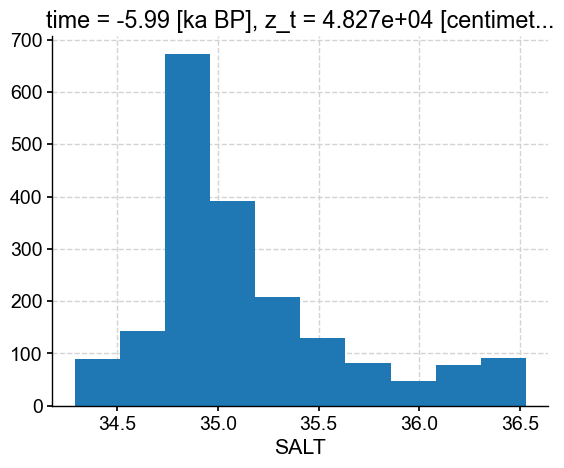

In [66]:
bins =c_snapshot_data_surf.plot.hist()
bin_edges = bins[1]

In [68]:
# establish scale
max_lim = bin_edges[-1]#c_snapshot_data.max()
min_lim = bin_edges[0]#c_snapshot_data.min()

In [69]:
var_pal = {'eNd':['red', 'blue'], 
          'SALT': 'BuGn',
          'd13C':'PRGn'}

In [70]:
n_levels= 20
ax2_levels = np.around(np.linspace(min_lim, max_lim, n_levels), decimals=4)#0.0026, .003, 15), decimals=6)
# make scalar mappable
ax2_sm = make_scalar_mappable([min_lim, max_lim],var_pal[var] , n_levels)#[0.0026, .003]
cf2_kwargs = {'cmap':ax2_sm.cmap,'levels':ax2_levels, 'norm' : ax2_sm.norm}#mpl.colors.TwoSlopeNorm(vmin=min_val, vcenter=0.0026, vmax=max_val), 'levels':ax2_levels}#SymLogNorm(.00152, linscale=.003)}#, vmin=None, vmax=None, clip=False)ax2_sm.norm}

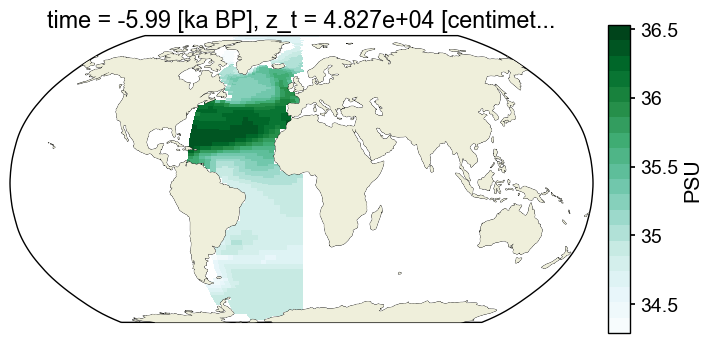

In [71]:
# plt.figure(figsize=(9,5));
fig = plt.figure(figsize=(8, 4))
# 1 row, 2 columns, .05 space between columns, 8:.3 ratio of left column to right column
gs = gridspec.GridSpec(1, 2, wspace=0.05, width_ratios=[8, .3])

# add subplot with specified map projection and coastlines (GeoAxes)
ax2 = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson(central_longitude=0))

c_snapshot_data_surf.plot.pcolormesh(ax=ax2, 
                                   transform=ccrs.PlateCarree(), 
                                   x='TLONG', y='TLAT', 
                                   levels=ax2_levels, 
                                  cmap=cf2_kwargs['cmap'], 
                                  norm=cf2_kwargs['norm'], 
                                  add_colorbar=False);

ax2.coastlines(linewidth=.5)
ax2.add_feature(cfeature.LAND, zorder=14)

ax2_cb = fig.add_subplot(gs[0, 1])
cb2 = plt.colorbar(ax2_sm,cax=ax2_cb, orientation='vertical',label=colorbar_units,
                   format=FormatStrFormatter('%g'))

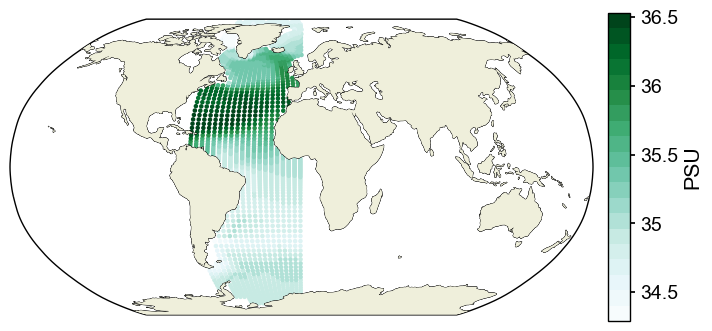

In [73]:
fig = plt.figure(figsize=(8, 4))
# 1 row, 2 columns, .05 space between columns, 8:.3 ratio of left column to right column
gs = gridspec.GridSpec(1, 2, wspace=0.05, width_ratios=[8, .3])

# add subplot with specified map projection and coastlines (GeoAxes)
ax2 = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson(central_longitude=0))
ax2.add_feature(cfeature.COASTLINE, edgecolor='k',linewidth=.5)

ax2.scatter(c_snapshot_data_surf.TLONG,c_snapshot_data_surf.TLAT,c=c_snapshot_data_surf, 
            transform=ccrs.PlateCarree(), 
            cmap=cf2_kwargs['cmap'], 
            norm=cf2_kwargs['norm'], 
             s=5)

ax2.coastlines(linewidth=.5)
ax2.add_feature(cfeature.LAND, zorder=14)

ax2_cb = fig.add_subplot(gs[0, 1])
cb2 = plt.colorbar(ax2_sm,cax=ax2_cb, orientation='vertical',label=colorbar_units,
                   format=FormatStrFormatter('%g'))


#### Shallow grave

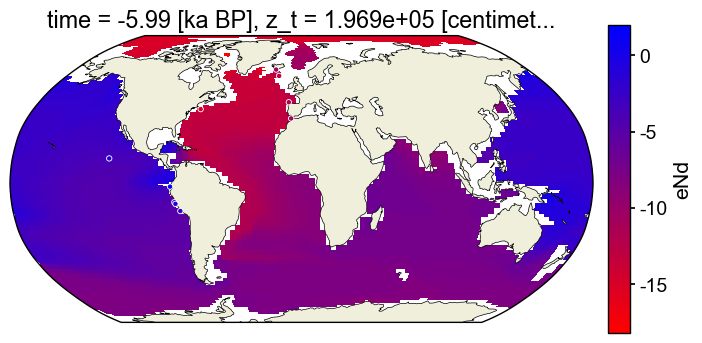

In [153]:
# plt.figure(figsize=(9,5));
fig = plt.figure(figsize=(8, 4))
# 1 row, 2 columns, .05 space between columns, 8:.3 ratio of left column to right column
gs = gridspec.GridSpec(1, 2, wspace=0.05, width_ratios=[8, .3])

# add subplot with specified map projection and coastlines (GeoAxes)
ax2 = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson(central_longitude=0))

c_snapshot_data_surf.plot.pcolormesh(ax=ax2, 
                                   transform=ccrs.PlateCarree(), 
                                   x='TLONG', y='TLAT', 
                                   levels=ax2_levels, 
                                  cmap=cf2_kwargs['cmap'], 
                                  norm=cf2_kwargs['norm'], 
                                  add_colorbar=False)

ax2.add_feature(cfeature.LAND, zorder=1)
ax2.coastlines(linewidth=.5, zorder = 1)

surface_df = time_subset[time_subset['depth'].between(500, 550)]
ax2.scatter(surface_df['lon'].apply(lambda x: lon_180_to_360(x)), surface_df['lat'], c=surface_df['eNd_HOL'],s=15, 
                norm=cf2_kwargs['norm'],cmap=cf2_kwargs['cmap'],
                edgecolors='w',linewidth=.63, transform=ccrs.PlateCarree())

ax2_cb = fig.add_subplot(gs[0, 1])
cb2 = plt.colorbar(ax2_sm,cax=ax2_cb, orientation='vertical',label=colorbar_units,
                   format=FormatStrFormatter('%g'))

## Section with Scatter

In [135]:
lims = [340, 342]
sect_ds = between(subarea_ds, 'TLONG', lims)
sect_ds = sect_ds[var].squeeze()
sect_ds = sect_ds.compute()

lat_lims = [min(sect_ds.TLAT.mean(dim='nlon')), max(sect_ds.TLAT.mean(dim='nlon'))]
lon_lims = np.mean(lims)*np.ones(2)

In [133]:
def make_inset_map(ax, lats, lons, central_lon=0,central_lat=0):
    axin = inset_axes(ax, width=.25*5, height=.25*5, loc="lower right", 
                 axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                 axes_kwargs=dict(projection=ccrs.Orthographic(central_latitude=central_lat, 
                                                               central_longitude=central_lon)))
                                                               # central_lon)))

    axin.coastlines(linewidth=.5)
    axin.add_feature(cfeature.LAND, zorder=14)
    axin.plot(lons, lats, transform=ccrs.PlateCarree())
    axin.set_global()


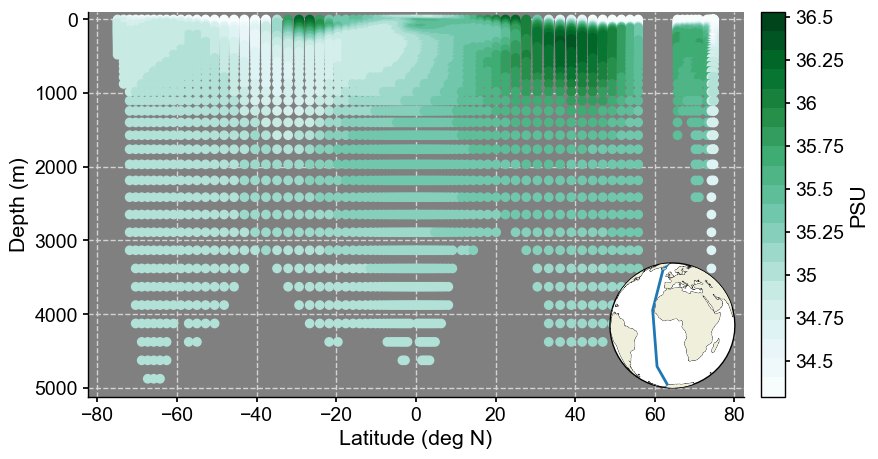

In [134]:
fig = plt.figure(figsize=(9,5));
gs = gridspec.GridSpec(1, 2, wspace=0.05, width_ratios=[8, .3])
ax = fig.add_subplot(gs[0, 0]);
# background color
ax.patch.set_facecolor('gray')

# for scatter, because color var is an array, need to make a mesh version of x and y vars
lat_mesh, depth_mesh = np.meshgrid(sect_ds.TLAT.mean(dim='nlon'), sect_ds.z_t_m)
ax.scatter(lat_mesh,depth_mesh,
                     c=sect_ds.mean(dim='nlon').squeeze().data,
                         cmap=ax2_sm.cmap, 
                        norm=ax2_sm.norm)


ylims = ax.get_ylim()
ax.set_ylim([ylims[1], max([-100,ylims[0]])])
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Latitude (deg N)')

ax2_cb = fig.add_subplot(gs[0, 1])
cb2 = plt.colorbar(ax2_sm,cax=ax2_cb, orientation='vertical',label=colorbar_units,
                   format=FormatStrFormatter('%g'))



make_inset_map(ax, lat_lims, lon_lims, central_lon=0,central_lat=0)



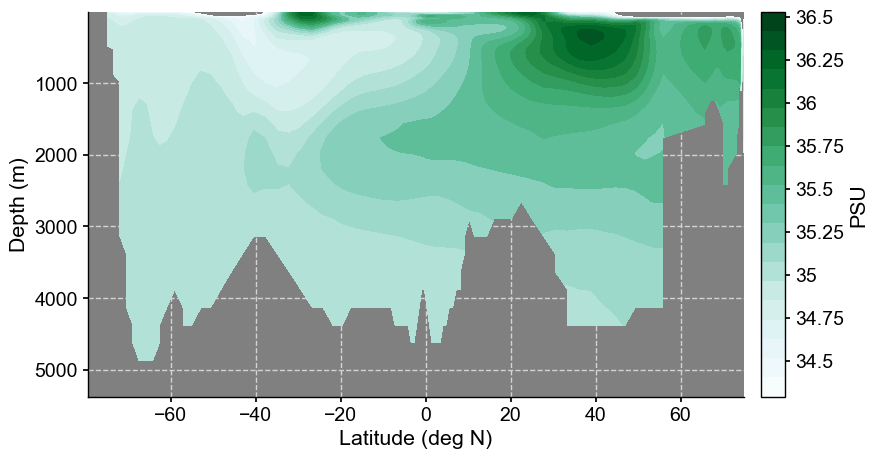

In [79]:
fig = plt.figure(figsize=(9,5));
gs = gridspec.GridSpec(1, 2, wspace=0.05, width_ratios=[8, .3])
ax = fig.add_subplot(gs[0, 0]);
# tmp = query_latlon(ds, lats=None, lons=[None])
ax.patch.set_facecolor('gray')

ax.contourf(sect_ds.TLAT.mean(dim='nlon'), sect_ds.z_t_m,
                     sect_ds.mean(dim='nlon').squeeze().data,10, origin='upper',
                         levels=ax2_levels,
                         cmap=ax2_sm.cmap, 
                        norm=ax2_sm.norm)


ylims = ax.get_ylim()
ax.set_ylim([ylims[1], ylims[0]])
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Latitude (deg N)')

ax2_cb = fig.add_subplot(gs[0, 1])
cb2 = plt.colorbar(ax2_sm,cax=ax2_cb, orientation='vertical',label=colorbar_units,
                   format=FormatStrFormatter('%g'))

## Model Grids 

Models are constructed according to some discritization scheme. Conceptually, this involves gridding the surface of the earth, but as a practical matter it is impossible to have grid cells of identical area and shape. 

Equal gridspacing: 
- Pro: Equal gridspacing is simple to understand and straightforward to query
- Con: Equal gridspacing causes numerical instabilities at the poles where lines of longitude converge and the cells become highly elongated and skewed.

Variable gridspacing:
- Pro: Accomodates poles more gracefully
- Con: Less intuitive to query

While most global scale models are run atop a non-cylindrical grid, in some cases the output is regridded as part of post-processing to make it easier to query, while in others, it's not. 

In [203]:
tmp = c_snapshot_data.where((c_snapshot_data.TLONG<342) & (c_snapshot_data.TLONG>340), drop=True)

---

## Summary
Xarray is rich in functions that support climate science related calculations. Here, we looked at a few that make it simpler to calculate anomalies and weighted averages, but don't stop here! Check out the [xarray documentation](https://docs.xarray.dev/en/stable/index.html) to see if there are other offerings that might facilitate your routine calculations! Additionally, plotting data on maps can be anywhere from mildly cumbersome to frustrating, depending on how particular you are about formatting.  Hopefully, the discussion here provided you with some tools to make map plotting more predictable. 

## What's next?
Check out our science bit about [climatic response to volcanic events]() to see how spatial snapshots of climate anomalies can be pulled together in a dashboard to get a multivariate overview.

## Resources and references


| _Citations_|
|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Kageyama, M., Braconnot, P., Harrison, S. P., Haywood, A. M., Jungclaus, J. H., Otto-Bliesner, B. L., Peterschmitt, J.-Y., Abe-Ouchi, A., Albani, S., Bartlein, P. J., Brierley, C., Crucifix, M., Dolan, A., Fernandez-Donado, L., Fischer, H., Hopcroft, P. O., Ivanovic, R. F., Lambert, F., Lunt, D. J., Mahowald, N. M., Peltier, W. R., Phipps, S. J., Roche, D. M., Schmidt, G. A., Tarasov, L., Valdes, P. J., Zhang, Q., and Zhou, T.: The PMIP4 contribution to CMIP6 – Part 1: Overview and over-arching analysis plan, Geosci. Model Dev., 11, 1033–1057, https://doi.org/10.5194/gmd-11-1033-2018, 2018.|